In [1]:
from scripts.model import EvalModel
import os
from scripts.datasets import SQUAD_dataset
from huggingface_hub import hf_hub_download
from scripts.download_dataset import DATASET_DIR
from scripts.custom_evaluate import evaluate_vqa
import torch

%load_ext autoreload
%autoreload 2

In [2]:
CHECKPOINT_DIR = (
    "/mnt/d/models/"
    if os.environ.get("CHECKPOINT_DIR") == None
    else os.environ["CHECKPOINT_DIR"]
)

model_args = {
    "vision_encoder_path": "ViT-L-14",
    "vision_encoder_pretrained": "openai",
    "lm_path": "anas-awadalla/mpt-1b-redpajama-200b",
    "lm_tokenizer_path": "anas-awadalla/mpt-1b-redpajama-200b",
    "checkpoint_path": f"{CHECKPOINT_DIR}fine-tuned-nl-flamingo/checkpoint.pt",
    #"checkpoint_path": "/mnt/d/models/OpenFlamingo-3B-vitl-mpt1b/checkpoint.pt",
    "cross_attn_every_n_layers": 1,
    "precision": "bf16",
    "device": 0,
}

model = EvalModel(
    model_args
)

/home/tovitu/.cache/huggingface/modules/transformers_modules/anas-awadalla/mpt-1b-redpajama-200b/50d6bc94e17812873f39c36c5f815263fa71fb80/attention.py:289: UserWarning: Using `attn_impl: torch`. If your model does not use `alibi` or `prefix_lm` we recommend using `attn_impl: flash` otherwise we recommend using `attn_impl: triton`.
  warnings.warn(


You are using config.init_device='cpu', but you can also use config.init_device="meta" with Composer + FSDP for fast initialization.
Flamingo model initialized with 1046992944 trainable parameters


In [3]:
from scripts.datasets import SQUAD_dataset

data = SQUAD_dataset()

In [4]:
import pprint

In [5]:
import json

with open('/mnt/d/datasets/psuedo_dataset.json', 'r') as f:
    pseudo = json.load(f)

In [8]:
import random
prompt_template = lambda question, context: f"Question: {question}\nContext: {context}\nRationale:"
#prompt_template = lambda question, context: f"Question: {question} Context: {context} Short Answer:"


instruction = '''
Suppose you are teaching a first grader. Answer the question according to
the provided context and explain to the first grader your method to find the
answer without referring back to the context in the form "Rationale:
<reasons>\n
Answer:<answer>" where <reasons> and <answer> are your response. Make your
response as short as possible.\n
'''
candidates = [text for text in pseudo.values() if 'Rationale' in text[len(instruction):]]

def make_in_context(shots=4):
    final = ""
    for shot in range(shots):
        candidate = candidates[int(random.random()*len(candidates))]
        final += candidate[len(instruction): ]+"<|endofchunk|>"
    return final

In [11]:
prediction = []
references = []

for idx in range(10):

    id = int(random.random() * len(data.val_dataset))

    sample = data.val_dataset[id]
    question = sample['question']
    context = sample['context']
    truth = sample['answers']['text'][0]


    prompt = prompt_template(question, context)
    image = data.palceholder_image
    image_token = data.image_preprocess_batch(model.image_processor, [image])

    in_context = make_in_context(shots=4)

    input_ids, attention_mask = model._prepare_text(prompt)
    output = model.model.generate(
        image_token.to(0, dtype=torch.bfloat16),
        input_ids,
        attention_mask,
        max_length = 1000,
        pad_token_id=50277,
        num_beams = 3
    )
    answer = model.tokenizer.decode(output[0])
    pprint.pprint(answer)
    print("=====================================================")
    pprint.pprint(truth)

    if input() == 'q':
        break

('Question: Compounding was not popular in the construction of what machines?\n'
 'Context: The adoption of compounding was common for industrial units, for '
 'road engines and almost universal for marine engines after 1880; it was not '
 'universally popular in railway locomotives where it was often perceived as '
 'complicated. This is partly due to the harsh railway operating environment '
 'and limited space afforded by the loading gauge (particularly in Britain, '
 'where compounding was never common and not employed after 1930). However, '
 'although never in the majority, it was popular in many other countries.\n'
 'Rationale: Compounding was not popular in the construction of machines.\n'
 'Answer: Compounding was not popular in the construction of '
 'machines.<|endofchunk|>')
'railway locomotives'
('Question: When did the term imperialism first come to be used by its current '
 'definition?\n'
 'Context: In anglophone academic works, theories regarding imperialism are '
 'of

In [7]:
import tqdm

predictions = []
references = []

with torch.no_grad():
    for idx in tqdm.tqdm(range(200)):
        sample = data.val_dataset[idx]
        question = sample['question']
        context = sample['context']
        truth = sample['answers']['text'][0]


        prompt = prompt_template(question, context)
        image = data.palceholder_image
        image_token = data.image_preprocess_batch(model.image_processor, [image])

        #in_context = make_in_context(shots=1)

        input_ids, attention_mask = model._prepare_text(prompt)
        output = model.model.generate(
            image_token.to(0, dtype=torch.bfloat16),
            input_ids,
            attention_mask,
            max_new_tokens = 100,
            pad_token_id=50277,
        )
        answer = model.tokenizer.decode(output[0])
        answer = answer.split("Answer:")[-1]

        answer = answer.replace("<|endofchunk|>", "")
        answer = answer.replace("\n", '')
        answer = data.processDigitArticle(answer)
        answer = data.processPunctuation(answer)

        pseudo_truth = data.processDigitArticle(truth)
        pseudo_truth = data.processPunctuation(truth)

        # if pseudo_truth.lower() in answer.lower():
        #     #print('gotcha')
        #     answer = pseudo_truth

        #print(answer)
        #print("Truth is " + truth)

        predictions.append({"prediction_text": answer, "id": sample["id"]})
        references.append({"answers": truth, "id": sample["id"]})

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [12:44<00:00,  3.82s/it]


In [8]:
# output_dir = '/mnt/d/datasets/'

# with open(output_dir + "squad_resutls.json", "w") as f:
#     f.write(json.dumps(predictions, indent=4))
# with open(output_dir + "squad_references.json", "w") as f:
#     f.write(json.dumps(references, indent=4))

In [9]:
references = []
for idx in tqdm.tqdm(range(len(predictions))):
    sample = data.val_dataset[idx]
    references.append({'id':sample['id'], 'answers':sample['answers']})

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 16157.73it/s]


In [11]:
from evaluate import load
# with open(f"{DATASET_DIR}squad_resutls.json", "r") as f:
#     predictions_ = json.load(f)
# with open(f"{DATASET_DIR}squad_references.json", "r") as f:
#     references_ = json.load(f)

squad_metric = load("squad")
results = squad_metric.compute(predictions=predictions, references=references)
print(results)

{'exact_match': 0.0, 'f1': 2.7710237785145493}


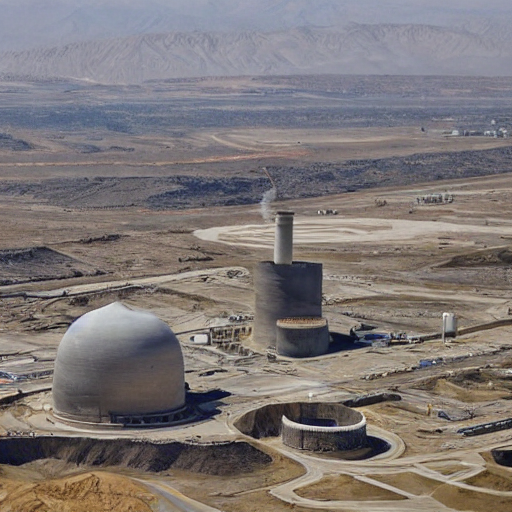

In [136]:
import PIL

sample = data.train_dataset[0]
id = sample['id']
PIL.Image.open(f'/mnt/d/datasets/images/572ff0a2947a6a140053ce38.png')

In [127]:
with open('/mnt/d/datasets/image_prompts.json', 'r') as f:
    image_prompts = json.load(f)

In [135]:
image_prompts['572ff0a2947a6a140053ce38']

' oil, fossil fuels, natural gas, UNESCO World Heritage Sites, Iran, Tehran, cultural legacy, economic center, international energy security.'